In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
import cv2
import moviepy.editor as mp
from moviepy.video.io.bindings import mplfig_to_npimage
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from moviepy.editor import VideoFileClip, ImageSequenceClip, CompositeVideoClip
from moviepy.video.io.bindings import mplfig_to_npimage


In [14]:
import json
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random


def timeline_creator(video_file, keysteps, subject_id, trial_id):
        
    # Extract temporal segments from 'keysteps'
    segments = []
    for keystep in keysteps:
        start, end = keystep['start_t'], keystep['end_t']
        label = keystep['label']
        segments.append((start, end, label))


    video_file_name = video_file.split('/')[-1]

    print("Video file:", video_file)
    print("Segments:", segments)

    # Generate a custom color palette for unique labels
    unique_labels = sorted(set([label for _, _, label in segments]))
    palette = sns.color_palette("muted", len(unique_labels))

    # Shuffle the palette to randomize the color assignment
    random.shuffle(palette)

    color_map = {label: palette[i] for i, label in enumerate(unique_labels)}


    plot_output_dir = f"./output/plot/{subject_id}/{trial_id}"
    os.makedirs(plot_output_dir, exist_ok=True)

    # Open video file
    cap = cv2.VideoCapture(video_file)

    if not cap.isOpened():
        print("Error: Could not open video.")
    else:
        fps = cap.get(cv2.CAP_PROP_FPS)

        if fps == 0:
            print("Error: FPS value is zero, which might indicate an issue with the video file.")
        else:
            # Plot timeline
            fig, ax = plt.subplots(figsize=(10, 4))
            ax.set_xlim(0, max([end for _, end, _ in segments]))
            ax.set_ylim(0, 1)

            # Remove y-axis ticks, labels, and spines
            ax.yaxis.set_ticks([])
            ax.yaxis.set_ticklabels([])
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            # Set x-axis label
            ax.set_xlabel("Time (seconds)")

            # Track labels added to the legend
            labels_added = set()

            # Draw bars for each segment
            for start, end, label in segments:
                color = color_map[label]
                if label not in labels_added:
                    ax.broken_barh([(start, end - start)], (0.25, 0.5), facecolors=color, label=label)
                    labels_added.add(label)
                else:
                    ax.broken_barh([(start, end - start)], (0.25, 0.5), facecolors=color)

            # Add legend below the x-axis
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.30), ncol=4, frameon=False)

            # Sync video playback
            def update(frame):
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
                ret, frame_img = cap.read()
                if ret:
                    plt.imshow(cv2.cvtColor(frame_img, cv2.COLOR_BGR2RGB))
                return frame_img

            ani = FuncAnimation(fig, update, frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), interval=1000/fps)

            
            plt.tight_layout()

            # Save the timeline plot
            
            file_name = f"{video_file_name.split('.')[0]}_video_timeline"
            fig.savefig(f'{plot_output_dir}/{file_name}_timeline.png', bbox_inches='tight', transparent=False, dpi=300)

            plt.show()


            # Transparent version

            #         # Now create the transparent version with only the color bars
            # fig_transparent, ax_transparent = plt.subplots(figsize=(10, 4))
            # ax_transparent.set_xlim(0, max([end for _, end, _ in segments]))
            # ax_transparent.set_ylim(0, 1)

            # # Remove all axis elements for transparent version
            # ax_transparent.axis('off')

            # # Draw bars for each segment
            # for start, end, label in segments:
            #     color = color_map[label]
            #     ax_transparent.broken_barh([(start, end - start)], (0.25, 0.5), facecolors=color)

            
            # # Save the transparent version as PNG
            # fig_transparent.savefig(f'{plot_output_dir}/{file_name}_bars_only.png', bbox_inches='tight', transparent=True)

            # plt.show()

            
            # Now create another figure with x-axis and no legend
            fig_no_legend, ax_no_legend = plt.subplots(figsize=(16, 2))
            ax_no_legend.set_xlim(0, max([end for _, end, _ in segments]))
            ax_no_legend.set_ylim(0, 1)

            
            # Remove y-axis ticks, labels, and spines
            ax_no_legend.yaxis.set_ticks([])
            ax_no_legend.yaxis.set_ticklabels([])
            ax_no_legend.spines['left'].set_visible(False)
            ax_no_legend.spines['right'].set_visible(False)
            ax_no_legend.spines['top'].set_visible(False)

            # Set x-axis label
            ax_no_legend.set_xlabel("Time (seconds)")

            # Draw bars for each segment (same as before, but without the legend)
            for start, end, label in segments:
                color = color_map[label]
                ax_no_legend.broken_barh([(start, end - start)], (0.25, 0.5), facecolors=color)

            # Save the no-legend plot
            file_name_no_legend = f"{video_file_name.split('.')[0]}video_timeline_no_legend"
            fig_no_legend.savefig(f'{plot_output_dir}/{file_name_no_legend}_timeline.png', bbox_inches='tight', transparent=True)

            plt.show()

    cap.release()

**************************************************
{'file_id': 'GX010391_encoded_trimmed', 'file_path': '/standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/cardiac_arrest/0/GoPro/GX010391_encoded_trimmed.mp4', 'protocol': 'Cardiac Arrest - 2-1'}
Subject: ms1, Trial: 0
GoPro file name: GX010391_encoded_trimmed.mp4, GoPro file path: /standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/cardiac_arrest/0/GoPro/GX010391_encoded_trimmed.mp4
Keysteps: [{'keystep_id': '5_FuqYvMnm', 'start_t': 0, 'end_t': 6.60863, 'label': 'approach_patient', 'class_id': 0}, {'keystep_id': '5_1JZ1Tkf5', 'start_t': 6.609, 'end_t': 11.41892, 'label': 'check_responsiveness', 'class_id': 1}, {'keystep_id': '5_fRl1lC6p', 'start_t': 13.395, 'end_t': 15.77309, 'label': 'check_breathing', 'class_id': 3}, {'keystep_id': '5_u2JcKI3V', 'start_t': 11.419, 'end_t': 15.77309, 'label': 'check_pulse', 'class_id': 2}, {'keystep_id': '5_dfb1x5md', 'start_t': 19.50903, 'end_t': 22.50903, 'label': 'request_assistance', 'class

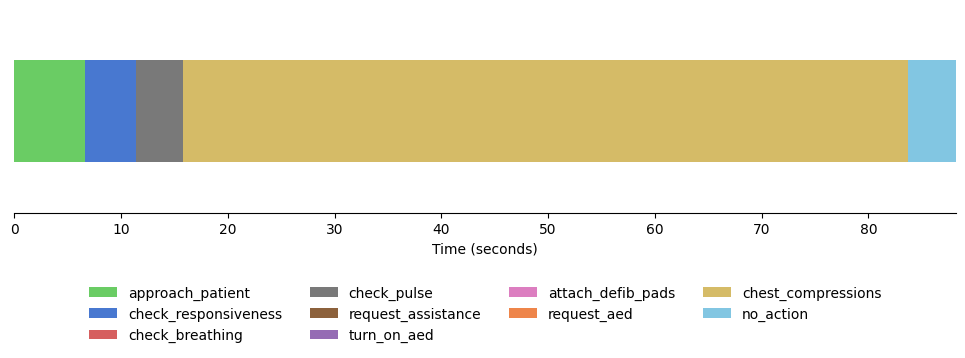

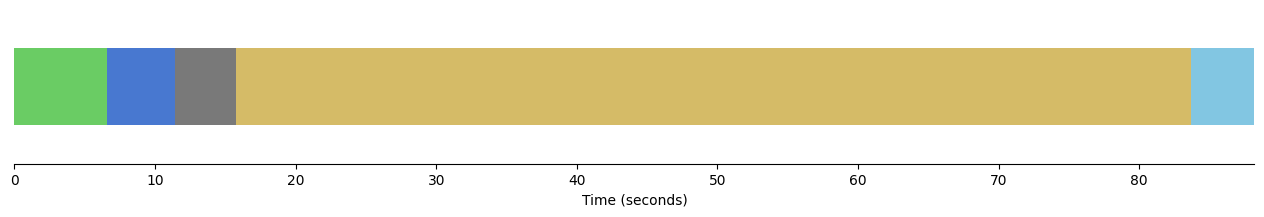

{'file_id': 'GX010392_encoded_trimmed', 'file_path': '/standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/cardiac_arrest/1/GoPro/GX010392_encoded_trimmed.mp4', 'protocol': 'Cardiac Arrest - 2-1'}
Subject: ms1, Trial: 1
GoPro file name: GX010392_encoded_trimmed.mp4, GoPro file path: /standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/cardiac_arrest/1/GoPro/GX010392_encoded_trimmed.mp4
Keysteps: [{'keystep_id': '6_zEsnuiOa', 'start_t': 0, 'end_t': 5.70439, 'label': 'approach_patient', 'class_id': 0}, {'keystep_id': '6_m1z9g4X7', 'start_t': 5.704, 'end_t': 7.98142, 'label': 'check_responsiveness', 'class_id': 1}, {'keystep_id': '6_HP0fMIIn', 'start_t': 7.981, 'end_t': 11.89809, 'label': 'check_pulse', 'class_id': 2}, {'keystep_id': '6_xef368p0', 'start_t': 9.215, 'end_t': 11.89809, 'label': 'check_breathing', 'class_id': 3}, {'keystep_id': '6_DItX8txT', 'start_t': 11.898, 'end_t': 54.21285, 'label': 'chest_compressions', 'class_id': 4}, {'keystep_id': '6_a666xgsV', 'start_t': 16.421

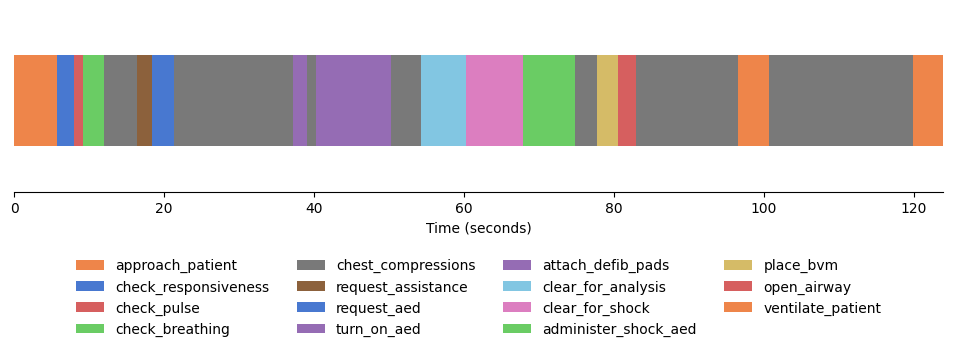

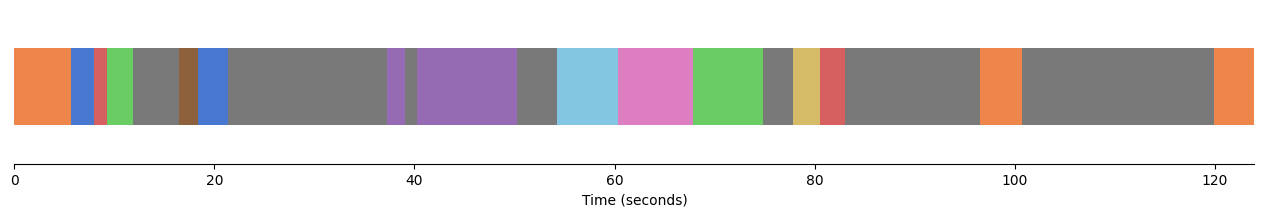

{'file_id': 'GX010393_encoded_trimmed', 'file_path': '/standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/cardiac_arrest/2/GoPro/GX010393_encoded_trimmed.mp4', 'protocol': 'Cardiac Arrest - 2-1'}
Subject: ms1, Trial: 2
GoPro file name: GX010393_encoded_trimmed.mp4, GoPro file path: /standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/cardiac_arrest/2/GoPro/GX010393_encoded_trimmed.mp4
Keysteps: [{'keystep_id': '7_LyCdYtnl', 'start_t': 0, 'end_t': 3.44495, 'label': 'approach_patient', 'class_id': 0}, {'keystep_id': '7_tkXo9GtX', 'start_t': 3.445, 'end_t': 6.04392, 'label': 'check_responsiveness', 'class_id': 1}, {'keystep_id': '7_BfywQIkI', 'start_t': 6.044, 'end_t': 11.25226, 'label': 'check_pulse', 'class_id': 2}, {'keystep_id': '7_hUkHrWey', 'start_t': 7.539, 'end_t': 11.25226, 'label': 'check_breathing', 'class_id': 3}, {'keystep_id': '7_jukWWWvo', 'start_t': 14.729, 'end_t': 16.50268, 'label': 'request_assistance', 'class_id': 6}, {'keystep_id': '7_fFKKuXa2', 'start_t': 17.378

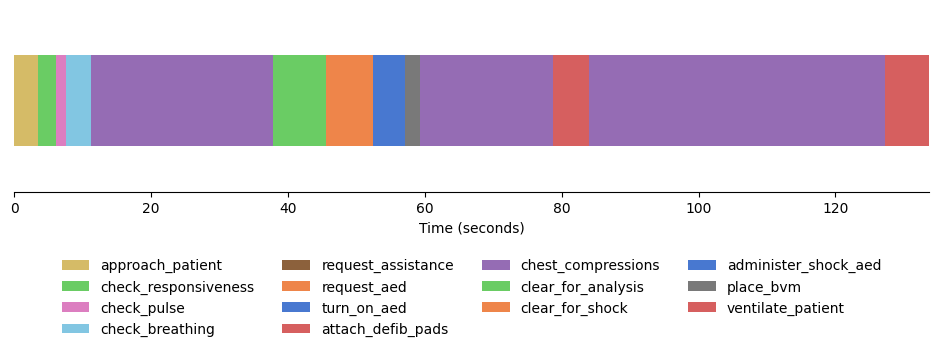

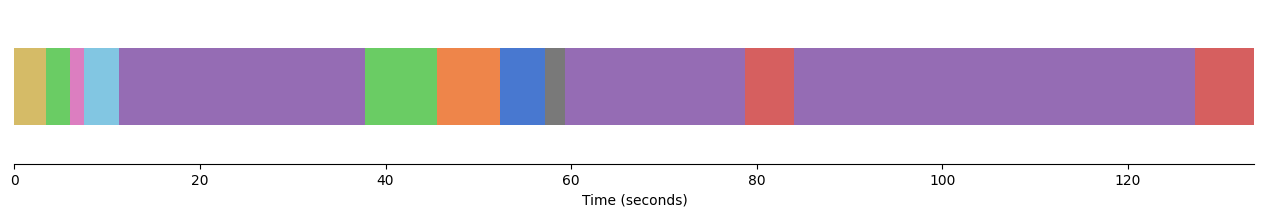

{'file_id': 'GX010394_encoded_trimmed', 'file_path': '/standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/cardiac_arrest/3/GoPro/GX010394_encoded_trimmed.mp4', 'protocol': 'Cardiac Arrest - 2-1'}
Subject: ms1, Trial: 3
GoPro file name: GX010394_encoded_trimmed.mp4, GoPro file path: /standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/cardiac_arrest/3/GoPro/GX010394_encoded_trimmed.mp4
Keysteps: [{'keystep_id': '8_0K8RKk2u', 'start_t': 0, 'end_t': 3.35642, 'label': 'approach_patient', 'class_id': 0}, {'keystep_id': '8_cdYj06Cb', 'start_t': 3.356, 'end_t': 6.27612, 'label': 'check_responsiveness', 'class_id': 1}, {'keystep_id': '8_6s7XcOkN', 'start_t': 6.276, 'end_t': 10.50226, 'label': 'check_breathing', 'class_id': 3}, {'keystep_id': '8_27RVoSjU', 'start_t': 6.276, 'end_t': 10.50226, 'label': 'check_pulse', 'class_id': 2}, {'keystep_id': '8_X9Uamv1R', 'start_t': 12.768, 'end_t': 15.88177, 'label': 'request_assistance', 'class_id': 6}, {'keystep_id': '8_dMnTWDUA', 'start_t': 18.069

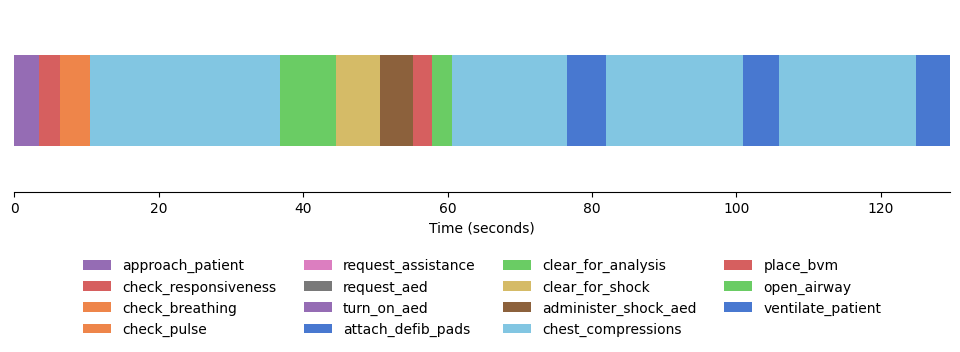

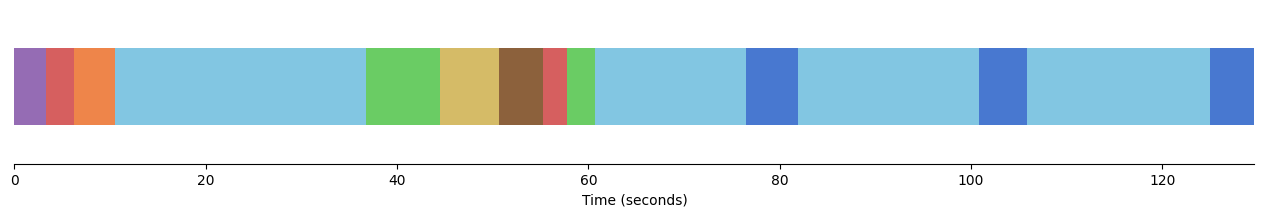

{'file_id': 'GX010400_encoded_trimmed', 'file_path': '/standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/cardiac_arrest/4/GoPro/GX010400_encoded_trimmed.mp4', 'protocol': 'Cardiac Arrest - 2-1'}
Subject: ms1, Trial: 4
GoPro file name: GX010400_encoded_trimmed.mp4, GoPro file path: /standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/cardiac_arrest/4/GoPro/GX010400_encoded_trimmed.mp4
Keysteps: [{'keystep_id': '9_J1h2RLTD', 'start_t': 0, 'end_t': 2.41892, 'label': 'approach_patient', 'class_id': 0}, {'keystep_id': '9_3NNLPBU5', 'start_t': 2.419, 'end_t': 5.27309, 'label': 'check_responsiveness', 'class_id': 1}, {'keystep_id': '9_wV6cV6dd', 'start_t': 5.273, 'end_t': 12.52309, 'label': 'check_pulse', 'class_id': 2}, {'keystep_id': '9_8aYeYEI4', 'start_t': 5.273, 'end_t': 12.52309, 'label': 'check_breathing', 'class_id': 3}, {'keystep_id': '9_Zk2jnoHi', 'start_t': 87.629, 'end_t': 92.092, 'label': 'no_action', 'class_id': 15}, {'keystep_id': '9_xlJILnZT', 'start_t': 17.00903, 'end_t

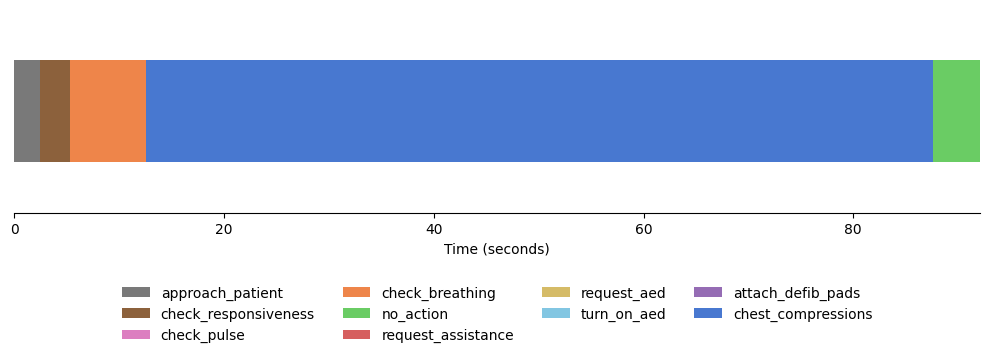

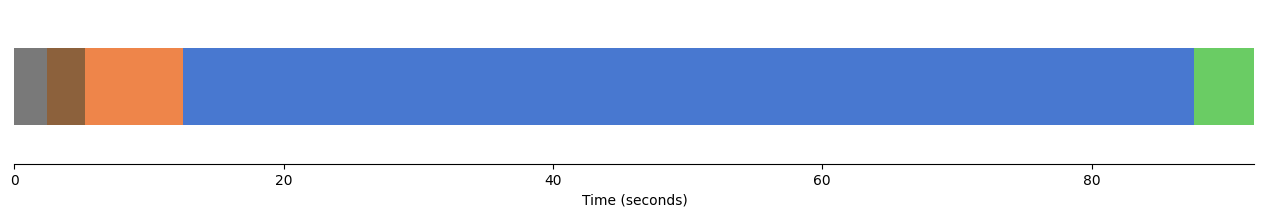

{'file_id': 'GX010401_encoded_trimmed', 'file_path': '/standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/cardiac_arrest/5/GoPro/GX010401_encoded_trimmed.mp4', 'protocol': 'Cardiac Arrest - 2-1'}
Subject: ms1, Trial: 5
GoPro file name: GX010401_encoded_trimmed.mp4, GoPro file path: /standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/cardiac_arrest/5/GoPro/GX010401_encoded_trimmed.mp4
Keysteps: [{'keystep_id': '1_iChLQfbQ', 'start_t': 0, 'end_t': 2.49139, 'label': 'approach_patient', 'class_id': 0}, {'keystep_id': '1_9YoHJBXD', 'start_t': 2.491, 'end_t': 4.67727, 'label': 'check_responsiveness', 'class_id': 1}, {'keystep_id': '1_kp3zPUL9', 'start_t': 4.677, 'end_t': 8.77286, 'label': 'check_pulse', 'class_id': 2}, {'keystep_id': '1_mIAtTTBs', 'start_t': 5.71403, 'end_t': 9.19197, 'label': 'check_breathing', 'class_id': 3}, {'keystep_id': '1_4I9YJnyp', 'start_t': 10.48142, 'end_t': 12.1, 'label': 'request_assistance', 'class_id': 6}, {'keystep_id': '1_IbjNjufA', 'start_t': 12.1, 'e

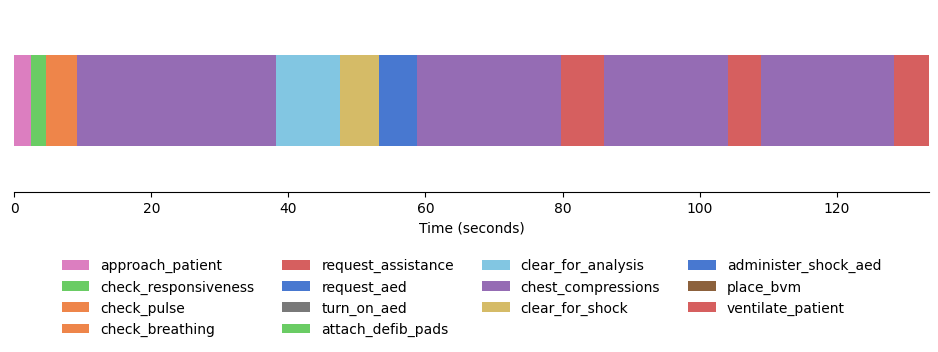

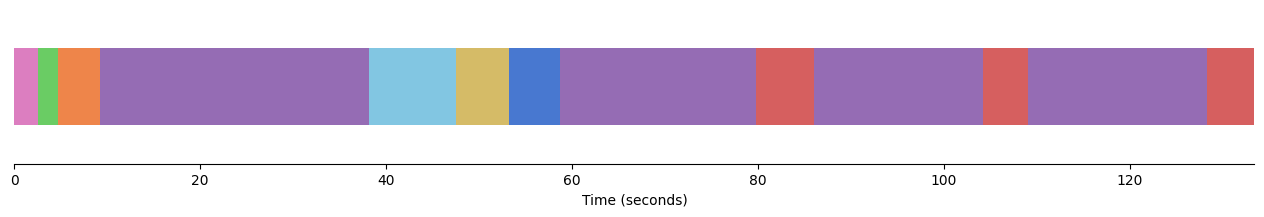

{'file_id': 'GX010408_encoded_trimmed', 'file_path': '/standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/chest_pain/6/GoPro/GX010408_encoded_trimmed.mp4', 'protocol': 'Cardiac Arrest - 2-1'}
Subject: ms1, Trial: 6
GoPro file name: GX010408_encoded_trimmed.mp4, GoPro file path: /standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/chest_pain/6/GoPro/GX010408_encoded_trimmed.mp4
Keysteps: [{'keystep_id': '2_m6osDpyq', 'start_t': 0.02858, 'end_t': 1.11192, 'label': 'approach_patient', 'class_id': 0}, {'keystep_id': '2_w1dW29a9', 'start_t': 24.613, 'end_t': 32.58575, 'label': 'explain_procedure', 'class_id': 17}, {'keystep_id': '2_qtMCbN3S', 'start_t': 1.32025, 'end_t': 25.59302, 'label': 'assess_patient', 'class_id': 16}, {'keystep_id': '2_hmlkGlw2', 'start_t': 32.586, 'end_t': 154.67151, 'label': 'assess_patient', 'class_id': 16}, {'keystep_id': '2_lTgRrbC2', 'start_t': 154.674, 'end_t': 163.15078, 'label': 'place_right_arm_lead', 'class_id': 20}, {'keystep_id': '2_A3XDXl4X', 'start

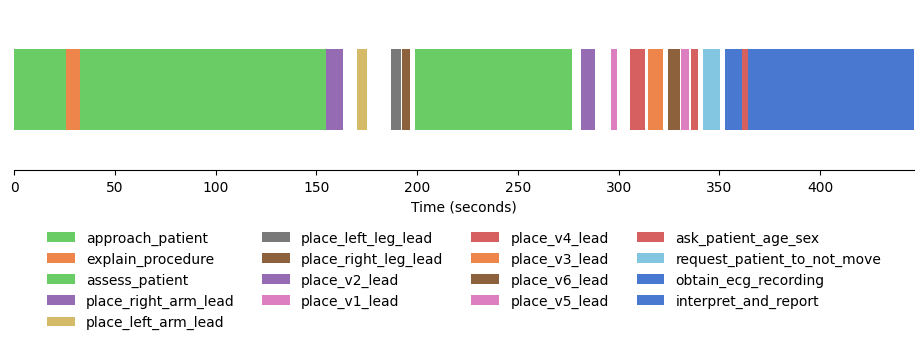

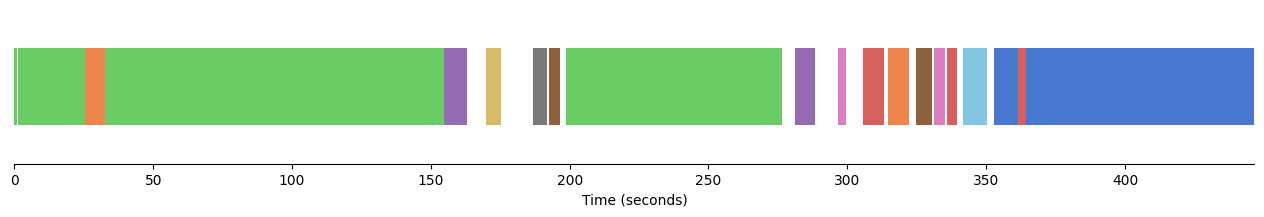

{'file_id': 'GX010409_encoded_trimmed', 'file_path': '/standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/chest_pain/7/GoPro/GX010409_encoded_trimmed.mp4', 'protocol': 'Cardiac Arrest - 2-1'}
Subject: ms1, Trial: 7
GoPro file name: GX010409_encoded_trimmed.mp4, GoPro file path: /standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/chest_pain/7/GoPro/GX010409_encoded_trimmed.mp4
Keysteps: [{'keystep_id': '3_50efjshr', 'start_t': 2.688, 'end_t': 37.40508, 'label': 'explain_procedure', 'class_id': 17}, {'keystep_id': '3_HunmOPyx', 'start_t': 56.308, 'end_t': 63.79731, 'label': 'place_right_arm_lead', 'class_id': 20}, {'keystep_id': '3_q3hdploh', 'start_t': 64.824, 'end_t': 73.71593, 'label': 'place_left_arm_lead', 'class_id': 19}, {'keystep_id': '3_eykkFrVm', 'start_t': 80.405, 'end_t': 82.62581, 'label': 'place_left_leg_lead', 'class_id': 21}, {'keystep_id': '3_0tBeANnj', 'start_t': 82.626, 'end_t': 90.4253, 'label': 'place_right_leg_lead', 'class_id': 22}, {'keystep_id': '3_Rv1xPPk0

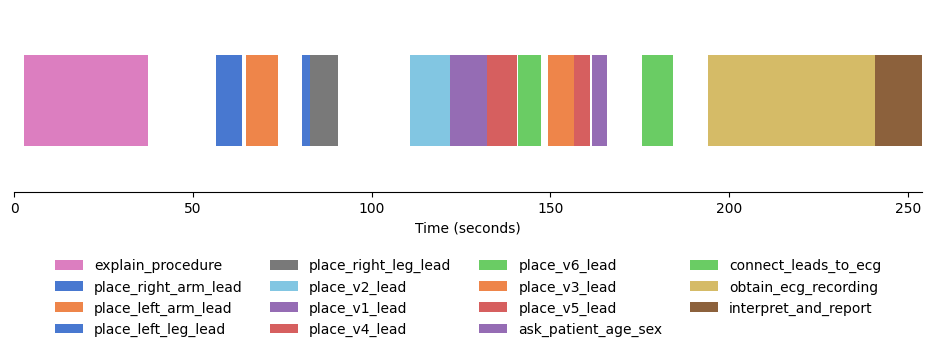

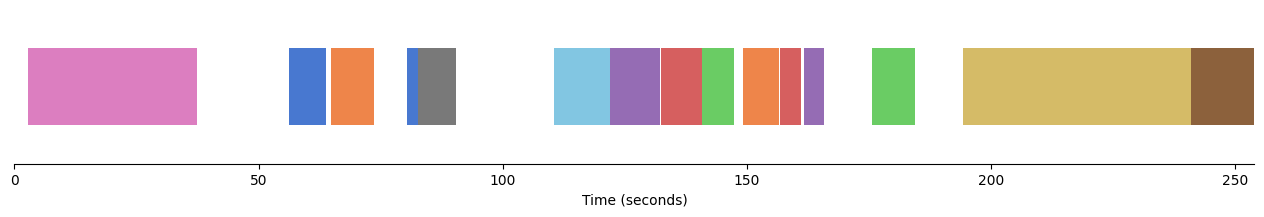

{'file_id': 'GX010410_encoded_trimmed', 'file_path': '/standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/chest_pain/8/GoPro/GX010410_encoded_trimmed.mp4', 'protocol': 'Cardiac Arrest - 2-1'}
Subject: ms1, Trial: 8
GoPro file name: GX010410_encoded_trimmed.mp4, GoPro file path: /standard/storage/EgoExoEMS_CVPR2025/Dataset/Final/ms1/chest_pain/8/GoPro/GX010410_encoded_trimmed.mp4
Keysteps: [{'keystep_id': '4_nEjAkhO3', 'start_t': 0.733, 'end_t': 5.73499, 'label': 'assess_patient', 'class_id': 16}, {'keystep_id': '4_laPwZEHl', 'start_t': 5.735, 'end_t': 22.42882, 'label': 'explain_procedure', 'class_id': 17}, {'keystep_id': '4_wxLJTu2D', 'start_t': 33.15358, 'end_t': 40.33527, 'label': 'place_right_arm_lead', 'class_id': 20}, {'keystep_id': '4_Si0bohI3', 'start_t': 44.237, 'end_t': 52.4094, 'label': 'place_left_arm_lead', 'class_id': 19}, {'keystep_id': '4_C5P7pqck', 'start_t': 53.341, 'end_t': 58.00761, 'label': 'place_right_leg_lead', 'class_id': 22}, {'keystep_id': '4_jcmlQ1jX', 's

KeyboardInterrupt: 

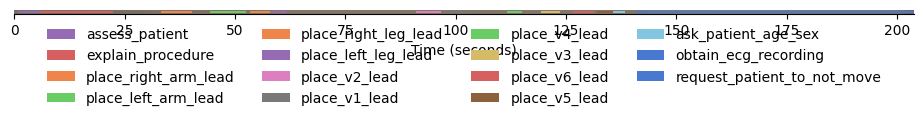

In [15]:
# Main annotation file
annotation_file = '../../Annotations/main_annotation_classification.json'

# load the annotation file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

    # iterate over each subject
    for subject in annotations['subjects']:
        print("*" * 50)
        subject_id = subject['subject_id']
        for trial in subject['trials']:
            trial_id = trial['trial_id']
            for stream_type, files in trial['streams'].items():
                if(stream_type == 'egocam_rgb_audio'):

                    gopro_file_name = None
                    gopro_file_path = None

                    print(files)


                    gopro_file_name = files['file_id']+ '.mp4'
                    gopro_file_path = files['file_path']


            if gopro_file_name:
                print(f"Subject: {subject['subject_id']}, Trial: {trial['trial_id']}")
                print(f"GoPro file name: {gopro_file_name}, GoPro file path: {gopro_file_path}")
                
                keysteps = trial['keysteps']
                
                # check if keysteps is not empty
                if not keysteps:
                    print("No keysteps found")
                else:
                    print(f"Keysteps: {keysteps}")
                    timeline_creator(gopro_file_path, keysteps, subject_id, trial_id)

                # print(f"Keysteps: {keysteps}")


In [ ]:
# output_dir = 'output'
# plot_output_dir = f'{output_dir}/plot'
# video_output_dir = f'{output_dir}/visualized_video'

# data_dir = '/standard/storage/CognitiveEMS_Datasets/anonymous/May_2024/DO_NOT_DELETE/ego_camera/clipped_with_audio/GX010305_clipped_with_audio.mp4'
# # annotations_file = '../../../Annotations/keysteps/GX010306_clipped_with_audio_KEYSTEP_ANNOTATION.json'
# annotations_file = '../../Annotations/keysteps/LATEST_KEYSTEPS.json'
# # annotations_file = '../../Annotations/main_annotation.json'

# # strip the file extension and add _with_timeline.mp4
# video_file = data_dir
# file_name = video_file.split('/')[-1]
# output_file = file_name.split('.')[0] + "_with_timeline_interventions.mp4"
# timeline_output_file = file_name.split('.')[0] + "_timeline_only.mp4"
# final_output_path = f'{video_output_dir}/{output_file}'
# print(f'output file: {final_output_path}')

# # make dirs if not exists
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# if not os.path.exists(plot_output_dir):
#     os.makedirs(plot_output_dir)
# if not os.path.exists(video_output_dir):
#     os.makedirs(video_output_dir)


In [ ]:
print(color_map)

## Visualize above on the video

In [ ]:

# Load the video with MoviePy
video_clip = VideoFileClip(video_file)
fps = video_clip.fps
duration = video_clip.duration

# Prepare to create timeline frames
frames = []

for t in np.linspace(0, duration, int(fps * duration)):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_xlim(0, max([end for _, end, _ in segments]))
    ax.set_ylim(0, 1)

    # Remove y-axis ticks, labels, and spines
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

    # set x axis label
    ax.set_xlabel("Time (seconds)")
    # Track which labels have been added to the legend
    labels_added = set()

    for start, end, label in segments:
        color = color_map[label]
        if label not in labels_added:
            ax.broken_barh([(start, end - start)], (0.25, 0.5), facecolors=color, label=label)
            labels_added.add(label)
        else:
            ax.broken_barh([(start, end - start)], (0.25, 0.5), facecolors=color)

    # Add legend below the x-axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.30), ncol=4, frameon=False)
    # Add a moving cursor
    ax.axvline(t, color='red', linewidth=2)
    
    fig.tight_layout()
    fig.canvas.draw()
    
    img_plot = np.array(fig.canvas.renderer.buffer_rgba())
    frames.append(img_plot)
    plt.close(fig)
    # break


# Create a clip from the frames
timeline_clip = ImageSequenceClip(frames, fps=fps)
timeline_clip = timeline_clip.set_duration(duration).resize(width=video_clip.w)

timeline_output_path = f'{video_output_dir}/{timeline_output_file}'
timeline_clip.write_videofile(timeline_output_path, fps=fps)



### Use ffmpeg to combine videos

In [3]:
!module load ffmpeg

In [ ]:
! ffmpeg

In [ ]:
# execute shell commmand
original_file = data_dir
timeline_output_path = f'{video_output_dir}/{timeline_output_file}'


# replace spaces with \ in the file path
original_file = original_file.replace(' ', '\ ')
# update command to forcefully overwrite the output file
command = f'module load ffmpeg && ffmpeg -i {original_file} -i {timeline_output_path} -filter_complex "[1:v]fps=fps=30[v1];[0:v][v1]vstack=inputs=2" -c:v libx264 -c:a copy -r 30 -y {final_output_path}'

# import subprocess to execute the command
! {command}
# import subprocess as sp

# # execute the command
# sp.run(command, shell=True)


In [92]:
frames[0].shape
# convert to pil image
from PIL import Image
img = Image.fromarray(frames[0])

# save image
img.save('test.png')



### Code to visualize label on the video

In [11]:
import json
import cv2
import matplotlib.pyplot as plt

# Load VIA annotation file
annotation_file = './via_project_28Aug2024_11h02m15s.json'

with open(annotation_file, 'r') as file:
    annotations = json.load(file)

# Extract relevant information from the JSON
video_info = annotations['file']['1']
video_filename = video_info['fname']
metadata = annotations['metadata']

# Load the video
cap = cv2.VideoCapture(video_filename)
frame_rate = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
output_filename = 'annotated_video_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format
out = cv2.VideoWriter(output_filename, fourcc, frame_rate, (frame_width, frame_height))

# Function to add annotation text on frames
def add_annotation(frame, text):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (50, 50)
    font_scale = 1
    color = (255, 0, 0)
    thickness = 2
    frame = cv2.putText(frame, text, org, font, font_scale, color, thickness, cv2.LINE_AA)
    return frame

# Process each annotation and save to video
for key, value in metadata.items():
    # Extract start time, end time, and label
    start_time = value['z'][0]
    end_time = value['z'][1]
    label = value['av']['1']
    
    # Convert times to frame numbers
    start_frame = int(start_time * frame_rate)
    end_frame = int(end_time * frame_rate)
    
    # Set the video to the start frame of the segment
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Write frames with annotation to output video
    for frame_num in range(start_frame, end_frame + 1):
        ret, frame = cap.read()
        if ret:
            # Add annotation text to frame
            annotated_frame = add_annotation(frame, f"Label: {label}")
            # Write the frame to the output video
            out.write(annotated_frame)
        else:
            print(f"Failed to read frame at {frame_num}.")
            break

# Release the video capture and writer objects
cap.release()
out.release()

print(f"Annotated video saved to {output_filename}")
